## Importation de bibliothèques

In [1]:
%matplotlib inline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, adjusted_rand_score#, make_scorer
# from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from string import punctuation
import torch
from transformers import BertTokenizer, BertModel
from wordcloud import WordCloud
from ydata_profiling import ProfileReport
 

## Aperçu des informations sur les produits, y compris l'analyse univariée et bivariée

In [2]:
flipkart_df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
profile = ProfileReport(flipkart_df, html={"style": {"full_width": True}})

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Suppression de colonnes non pertinentes pour l'étude

In [3]:
flipkart_df = flipkart_df[
    [
        "product_name",
        "product_category_tree",
        "image",
        "description",
        "product_specifications",
    ]
]

display(flipkart_df)


product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >>...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
...                                                 ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                 product_specifications  
0     {"product_specification"=>[{"key"=>"Brand", "v...  
1     {"product_specification"=>[{"key"=>"Machine Wa...  
2     {"product_specification"=>[{"key"=>"Material",...  
3     {"product_specification"=>[{"key"=>"Brand", "v...  
4     {"product_specification"=>[{"key"=>"Machine Wa...  
...                                                 ...  
1045  {"product_specification"=>[{"key"=>"Number of ...  
1046  {"product_specification"=>[{"key"=>"Number of ...  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...  

[1050 rows x 5 columns]

## Parsage de l'arborescence des catégories de produits et des spécifications des produits

In [4]:
outside_strip_patrn = re.compile(r'\["(.+?)(\.\.\.)?"\]')
key_val_patrn = re.compile(r'"key"=>"(.+?)", "value"=>"(.+?)"')


def parse_categ_tree(categ_tree):
    return re.match(outside_strip_patrn, categ_tree).group(1).split(" >> ")


def parse_prod_specs(prod_specs):
    specs_dict = {}

    if not pd.isnull(prod_specs):
        for match in re.findall(key_val_patrn, prod_specs):
            specs_dict[match[0]] = match[1]

    return specs_dict


with pd.option_context("mode.chained_assignment", None):
    flipkart_df["product_category_tree"] = flipkart_df["product_category_tree"].apply(
        parse_categ_tree
    )
    flipkart_df["product_specifications"] = flipkart_df["product_specifications"].apply(
        parse_prod_specs
    )


## Ajout de colonnes pour chaque niveau de sous-catégories

In [5]:
flipkart_w_subcat_df = flipkart_df.copy()

for i in range(1, len(max(flipkart_w_subcat_df.product_category_tree, key=len)) + 1):
    flipkart_w_subcat_df[f"subcateg_{i}"] = np.nan


def fill_subcategs(row):
    for i in range(0, len(row["product_category_tree"])):
        row[f"subcateg_{i + 1}"] = row["product_category_tree"][i]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(fill_subcategs, axis=1)

flipkart_w_subcat_df.head(3)


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   
1  [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
2  [Baby Care, Baby Bath & Skin, Baby Bath Towels...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   
1  {'Machine Washable': 'Yes', 'Material': 'Cotto...        Baby Care   
2  {'Material': 'Cotton Terry', 'Design': 'SHUVAM...        Baby Care   

               subcateg_2        subcateg_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   

                                         subcateg_4  \
0  Elegance Polyester Multicolor Abstract Eyelet Do   
1                         Sathiyas Baby Bath Towels   
2                          Eurospa Baby Bath Towels   

                                         subcateg_5 subcateg_6 subcateg_7  
0                                               NaN        NaN        NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y        NaN        NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE FA        NaN        NaN

## Dénombrement des sous-catégories secondaires

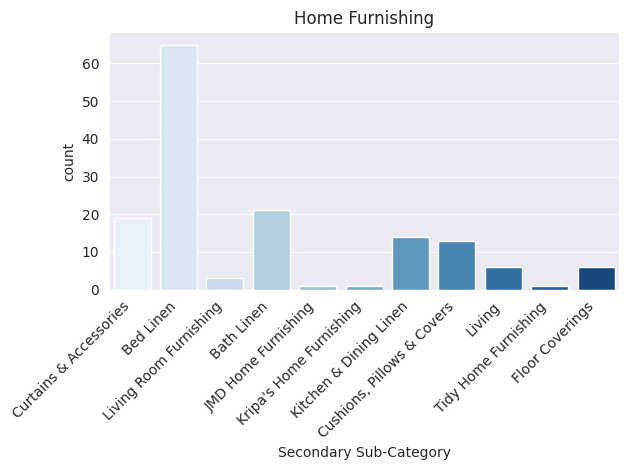

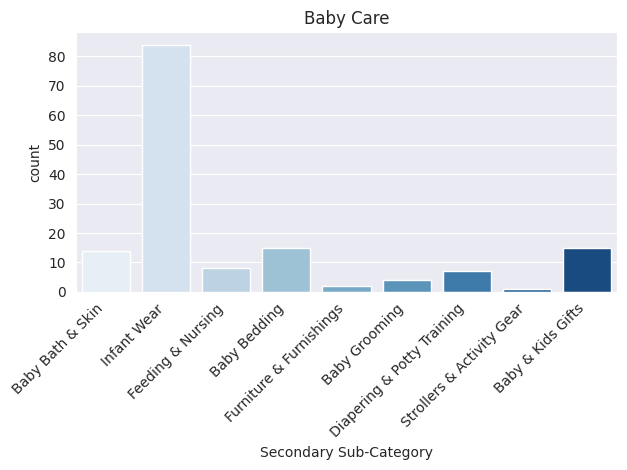

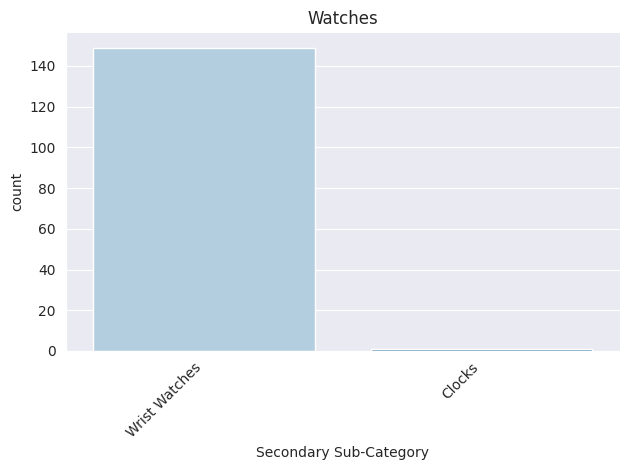

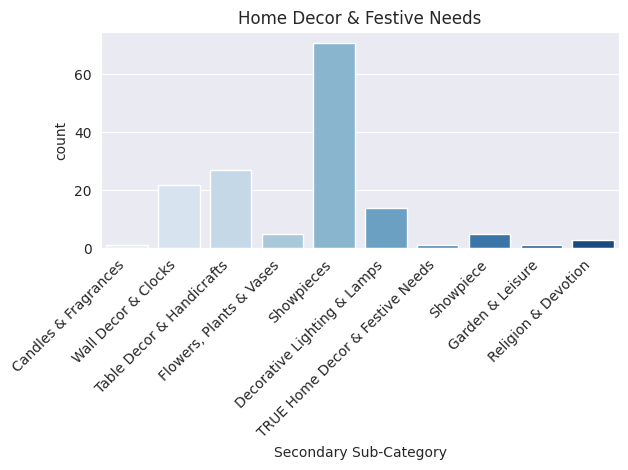

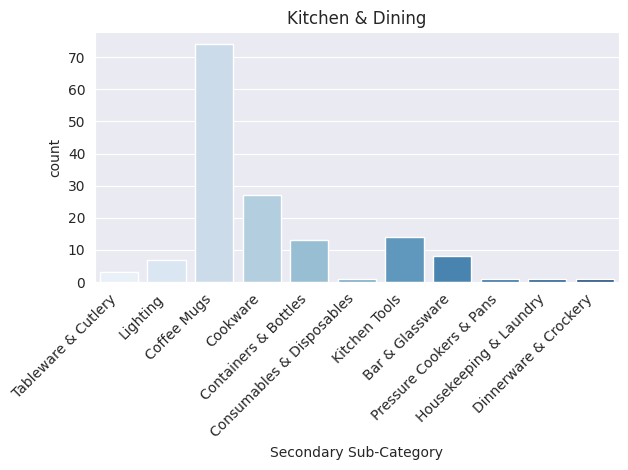

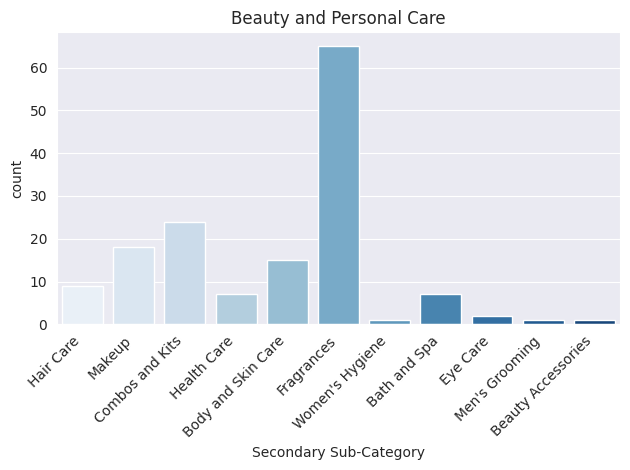

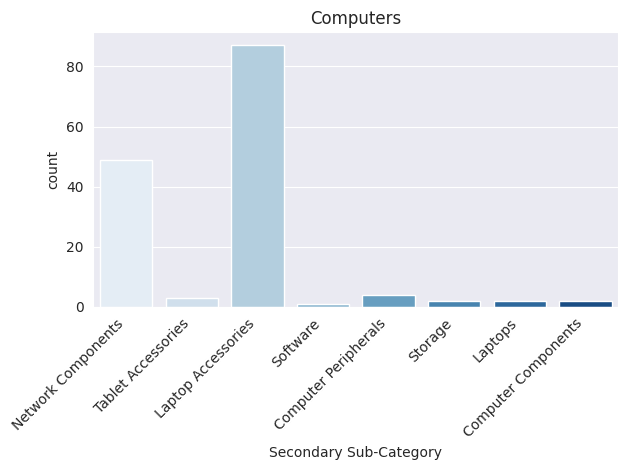

In [6]:
sns.set_style("darkgrid")

for subcateg_1 in flipkart_w_subcat_df["subcateg_1"].unique().tolist():
    sns.countplot(
        x="subcateg_2",
        data=flipkart_w_subcat_df.loc[flipkart_w_subcat_df["subcateg_1"] == subcateg_1],
        palette="Blues",
    )
    plt.title(subcateg_1)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Secondary Sub-Category")
    plt.tight_layout()
    plt.show()


## Affichage des profondeurs de l'arborescence des catégories

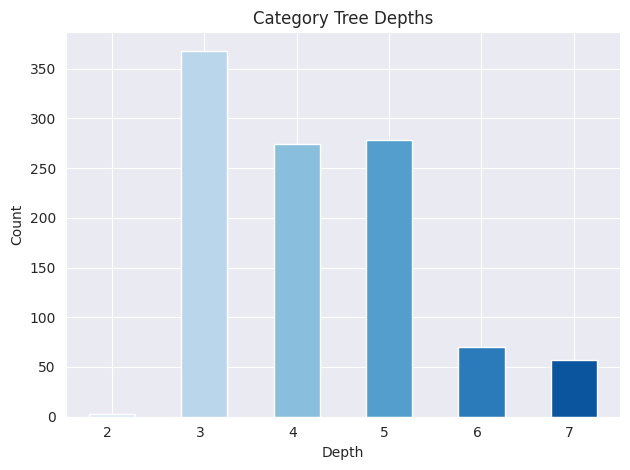

In [7]:
pd.Series(
    [len(x) for x in flipkart_w_subcat_df["product_category_tree"].to_list()]
).value_counts().sort_index().plot.bar(color=sns.color_palette("Blues").as_hex())
plt.title("Category Tree Depths")
plt.xticks(rotation=0, ha="right")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Suppression des informations de catégorie des spécifications des produits

In [8]:
def remove_prod_spec_categ(row):
    if "Category" in row["product_specifications"].keys():
        del row["product_specifications"]["Category"]

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(remove_prod_spec_categ, axis=1)


## Ajout d'une chaîne de valeurs des spécifications du produit

In [9]:
def add_prod_spec_str(row):
    if len(row["product_specifications"].items()) > 0:
        row["product_specifications_str"] = " ".join(
            list(row["product_specifications"].values())
        )
    else:
        row["product_specifications_str"] = ""

    return row


flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_prod_spec_str, axis=1)

flipkart_w_subcat_df.head(1)


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  
0        NaN  Elegance Door Eyelet Abstract Polyester Door C...

## Prétraitement de texte préliminaire
- Conversion de chaînes en minuscules
- Tokénisation
- Suppression des mots vides et de la ponctuation
- Lemmatisation

In [10]:
preproc_feats = ["product_name", "description", "product_specifications_str"]
tokenized_feats = [x + "_tokens" for x in preproc_feats]
stopwords = nltk.corpus.stopwords.words("english")
punctuation = list(punctuation)
lemmatizer = nltk.stem.WordNetLemmatizer()


def to_lower(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat] = row[preproc_feat].lower()

    return row


def add_tokens(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat + "_tokens"] = nltk.tokenize.word_tokenize(row[preproc_feat])

    return row


def del_stpwrd_pnct(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x
            for x in row[tokenized_feat]
            if x not in stopwords and x not in punctuation
        ]

    return row


def lemmatize(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [lemmatizer.lemmatize(x) for x in row[tokenized_feat]]

    return row


nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

flipkart_w_subcat_df = flipkart_w_subcat_df.apply(to_lower, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_tokens, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(del_stpwrd_pnct, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(lemmatize, axis=1)

flipkart_w_subcat_df.head(1)


[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gabriel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


product_name  \
0  elegance polyester multicolor abstract eyelet ...   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  key features of elegance polyester multicolor ...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  \
0        NaN  elegance door eyelet abstract polyester door c...   

                                 product_name_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   

                                  description_tokens  \
0  [key, feature, elegance, polyester, multicolor...   

                   product_specifications_str_tokens  
0  [elegance, door, eyelet, abstract, polyester, ...

## Mots les plus fréquents par catégorie et caractéristique

In [11]:
def word_stats_by_categ_feat(num_top_words=10):
    for main_categ in flipkart_w_subcat_df["subcateg_1"].unique():
        categ_df = flipkart_w_subcat_df.loc[
            flipkart_w_subcat_df["subcateg_1"] == main_categ
        ]
        previous_combined = []

        print(f"Primary category: {main_categ}")

        for tokenized_feat in tokenized_feats:
            top_words_list = (
                pd.Series(list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .value_counts()
                .nlargest(n=num_top_words)
                .index.to_list()
            )

            print(
                f"\t{num_top_words} top words in {tokenized_feat}:\n\t\t{top_words_list}"
            )

            all_words_list = (
                pd.Series(list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .unique()
                .tolist()
            )

            print(f"\tAll words in {tokenized_feat}:\n\t{all_words_list}")

            previous_combined += all_words_list

            previous_combined = list(set(previous_combined))

            print(f"\tNumber of words in {tokenized_feat}: {len(all_words_list)}")
            print(
                f"\tNumber of words in previous features combined: {len(previous_combined)}"
            )


word_stats_by_categ_feat()


Primary category: Home Furnishing
	10 top words in product_name_tokens:
		['cotton', 'single', 'abstract', 'double', 'floral', 'cover', 'quilt', 'blanket', 'comforter', 'polyester']
	All words in product_name_tokens:
	['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet', 'jaipur', 'print', 'floral', 'embroidered', 'diwan', 'set', 'house', 'queen', 'duvet', 'cover', 'riva', 'carpet', 'free', 'bath', 'mat', 'classic', 'loop', 'shag', 'bathmat_ri-527', 'jmd', 'cushion', 'kripa', "'s", 'prime', '4', 'seater', 'table', '8', 'craft', 'trade', 'oval', 'wood', 'coaster', 'rama', 'single', 'quilt', 'comforter', 'pink-red', 'yellow', 'shop', 'rajasthan', 'dohar', 'artisan', 'creation', 'checkered', 'brown', 'blue-beige', 'remtex', 'export', 'cartoon', 'india', 'bhavya', 'velvet', 'sofa', 'dreamshomes', 'jewelkraft', 'design', 'pink', 'linen', 'tidy', 'jbc', 'collection', 'lushome

## Nuage de mots des noms et descriptions combinés dans la catégorie ameublement

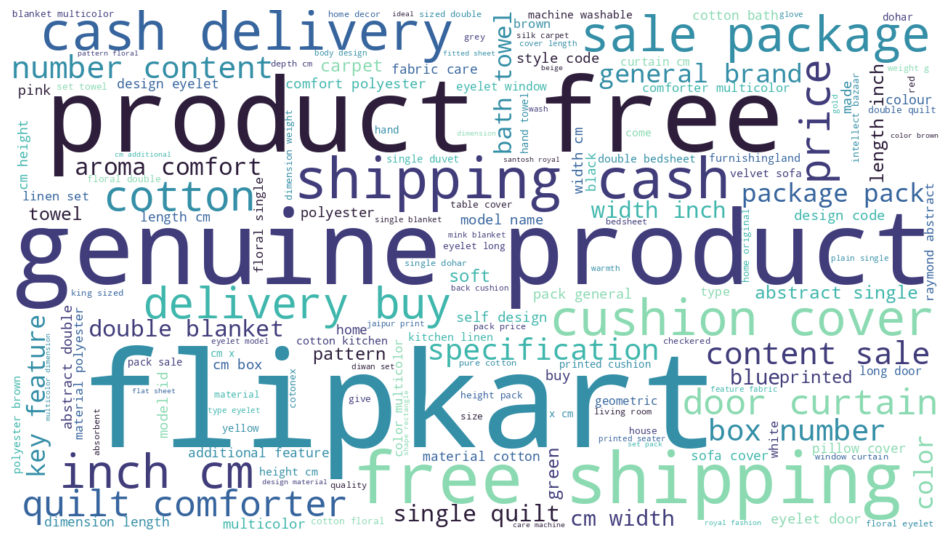

In [12]:
home_furnishing_df = flipkart_w_subcat_df.loc[
    flipkart_w_subcat_df["subcateg_1"] == "Home Furnishing"
]
home_furnishing_words = " ".join(
    list(np.concatenate(home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Suppression de bruit (mots superflus)
Par exemple :
- URLs
- Numéros de modèle
- Chiffres
- Suffixes en suspension

In [13]:
noise_patrn = re.compile(r".*?\w\.\w.*|.*?\d+.*|^'.*|^-.*|^.$|.*?/.*")


def remove_noise(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x for x in row[tokenized_feat] if not re.match(noise_patrn, x)
        ]

    return row


flipkart_w_subcat_wo_noise_df = flipkart_w_subcat_df.apply(remove_noise, axis=1)


## Suppression de mots en fonction de la fréquence inter et intra-catégorie
- Si un mot apparaît dans plus d'une autre catégorie
- Si un mot apparaît pour moins de 2 % des produits au sein d'une catégorie

In [14]:
inter_categ_thresh = 2
intra_categ_thresh = 0.02

word_counts_by_categ = {}
words_to_remove_by_inter_categ = {}
words_to_remove_by_intra_categ = {}
entries_per_categ = {}
main_categ_list = flipkart_w_subcat_wo_noise_df["subcateg_1"].unique()
known_irrel_words = [
    "buy",
    "genuine",
    "product",
    "day",
    "replacement",
    "guarantee",
    "free",
    "shipping",
    "cash",
    "delivery",
    "discount",
]

for main_categ in main_categ_list:
    categ_df = flipkart_w_subcat_wo_noise_df.loc[
        flipkart_w_subcat_wo_noise_df["subcateg_1"] == main_categ
    ]
    word_counts_by_categ[main_categ] = (
        pd.Series(
            list(np.concatenate(categ_df["product_name_tokens"].to_list()).flat)
            + list(np.concatenate(categ_df["description_tokens"].to_list()).flat)
        )
        .value_counts()
        .to_dict()
    )
    entries_per_categ[main_categ] = categ_df.shape[0]
    words_to_remove_by_inter_categ[main_categ] = []
    words_to_remove_by_intra_categ[main_categ] = []

for main_categ in main_categ_list:
    other_categs_list = [x for x in main_categ_list if x != main_categ]
    intra_categ_thresh_num = entries_per_categ[main_categ] * intra_categ_thresh

    for word in word_counts_by_categ[main_categ].keys():
        other_categs_found_in = 0

        for other_categ in other_categs_list:
            if word in word_counts_by_categ[other_categ].keys():
                other_categs_found_in += 1

        if other_categs_found_in > inter_categ_thresh:
            words_to_remove_by_inter_categ[main_categ] += [word]

        if word_counts_by_categ[main_categ][word] < intra_categ_thresh_num:
            words_to_remove_by_intra_categ[main_categ] += [word]


def remove_irrel_words(row, inter_categ_words_list, intra_categ_words_list):
    orig_product_name_tokens = row["product_name_tokens"].copy()
    orig_description_tokens = row["description_tokens"].copy()
    row["product_name_tokens"] = [
        x
        for x in row["product_name_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]
    row["description_tokens"] = [
        x
        for x in row["description_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in inter_categ_words_list
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in inter_categ_words_list
        ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in known_irrel_words
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in known_irrel_words
        ]

    return row


flipkart_no_irrel_df = flipkart_w_subcat_wo_noise_df.copy()

for main_categ in main_categ_list:
    flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ] = flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ].apply(
        remove_irrel_words,
        args=[
            words_to_remove_by_inter_categ[main_categ],
            words_to_remove_by_intra_categ[main_categ],
        ],
        axis=1,
    )


## Suppression des mots dupliqués de manière séquentielle / fin du prétraitement

In [15]:
def remove_repeats(row):
    tokens_feats = ["product_name_tokens", "description_tokens"]

    for tokens_feat in tokens_feats:
        repeats_removed = []
        last_token = ""

        for token in row[tokens_feat]:
            if token != last_token:
                repeats_removed += [token]

            last_token = token

        row[tokens_feat] = repeats_removed

    return row


def insert_cleaned_strings(row):
    row["product_name"] = " ".join(row["product_name_tokens"])
    row["description"] = " ".join(row["description_tokens"])

    return row


flipkart_no_irrel_df = flipkart_no_irrel_df.apply(remove_repeats, axis=1)
flipkart_clean_df = flipkart_no_irrel_df.apply(insert_cleaned_strings, axis=1)

flipkart_clean_df.head(1)


product_name  \
0  polyester eyelet door curtain   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  polyester eyelet door curtain floral curtain p...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  \
0        NaN  elegance door eyelet abstract polyester door c...   

                  product_name_tokens  \
0  [polyester, eyelet, door, curtain]   

                                  description_tokens  \
0  [polyester, eyelet, door, curtain, floral, cur...   

                   product_specifications_str_tokens  
0  [elegance, door, eyelet, abstract, polyester, ...

## Nuage de mots pour la catégorie d'ameublement après le prétraitement

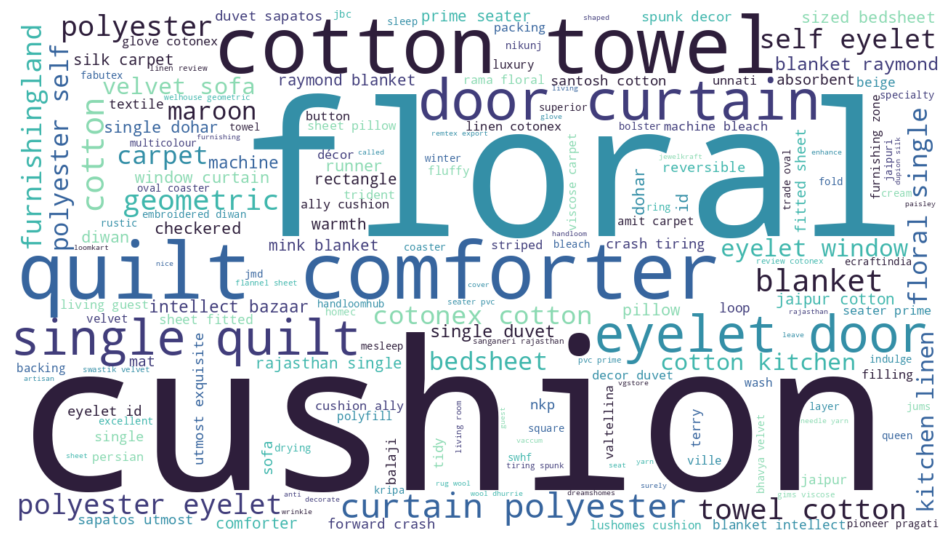

In [16]:
home_furnishing_df = flipkart_no_irrel_df.loc[
    flipkart_no_irrel_df["subcateg_1"] == "Home Furnishing"
]
home_furnishing_words = " ".join(
    list(np.concatenate(home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Visualisation des unigrammes et bigrammes les plus courants dans la catégorie d'ameublement

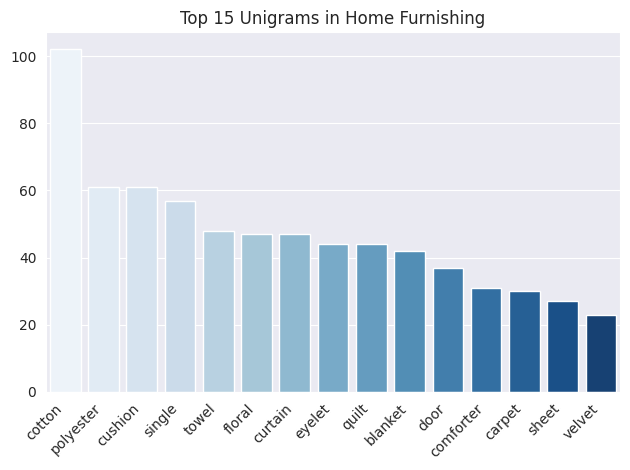

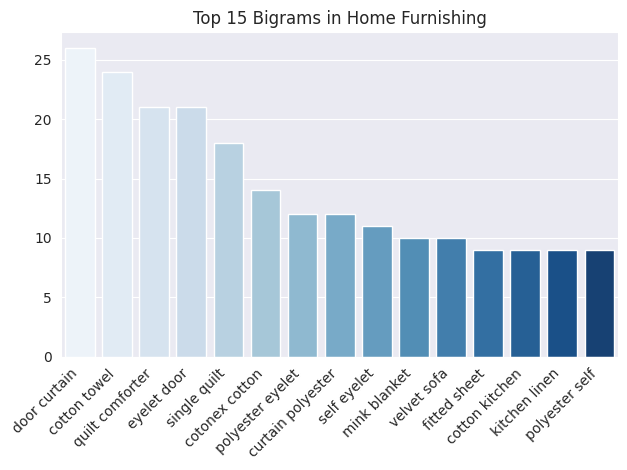

In [17]:
def generate_bigrams(row):
    desc_bigrams = []

    for i in range(len(row["description_tokens"]) - 1):
        desc_bigrams += [
            f"{row['description_tokens'][i]} {row['description_tokens'][i + 1]}"
        ]

    row["description_bigrams"] = desc_bigrams

    return row


flipkart_w_bigram_df = flipkart_clean_df.apply(generate_bigrams, axis=1)
home_furnishing_df = flipkart_w_bigram_df.loc[
    flipkart_w_bigram_df["subcateg_1"] == "Home Furnishing"
]
num_ngrams = 15

for feat in [["description_tokens", "Unigrams"], ["description_bigrams", "Bigrams"]]:
    top_ngram_list = (
        pd.Series(list(np.concatenate(home_furnishing_df[feat[0]].to_list()).flat))
        .value_counts()
        .nlargest(n=num_ngrams)
    )

    sns.barplot(x=top_ngram_list.index, y=top_ngram_list.values, palette="Blues")
    plt.title(f"Top {num_ngrams} {feat[1]} in Home Furnishing")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Simple Word Count, Unigrams Only - LDA Topics (Top 10 N-grams):
	Topic Watches: ['watch', 'analog', 'discount', 'dial', 'strap', 'round', 'maximum', 'sonata', 'idol', 'ganesha']
	Topic Computers: ['usb', 'port', 'oil', 'fan', 'carpet', 'poster', 'android', 'phone', 'devic', 'otg']
	Topic Home Furnishing: ['cotton', 'mug', 'towel', 'coffe', 'singl', 'bedsheet', 'cushion', 'sheet', 'quilt', 'printland']
	Topic Baby Care: ['cotton', 'dress', 'sleev', 'neck', 'occas', 'shirt', 'round', 'gather', 'regular', 'stripe']
	Topic Home Decor & Festive Needs: ['showpiec', 'pizza', 'sticker', 'hair', 'decor', 'brass', 'cutter', 'paint', 'frame', 'eleph']
	Topic Kitchen & Dining: ['laptop', 'mug', 'rockmantra', 'pad', 'polyest', 'dishwash', 'microwav', 'curtain', 'glass', 'start']
	Topic Computers: ['mug', 'adapt', 'laptop', 'coffe', 'vaio', 'charger', 'usb', 'smartpro', 'cell', 'lapguard']
Simple Word Count, Unigrams and Bigrams - LDA Topics (Top 10 N-grams):
	Topic Home Furnishing: ['adapt', 'vaio'

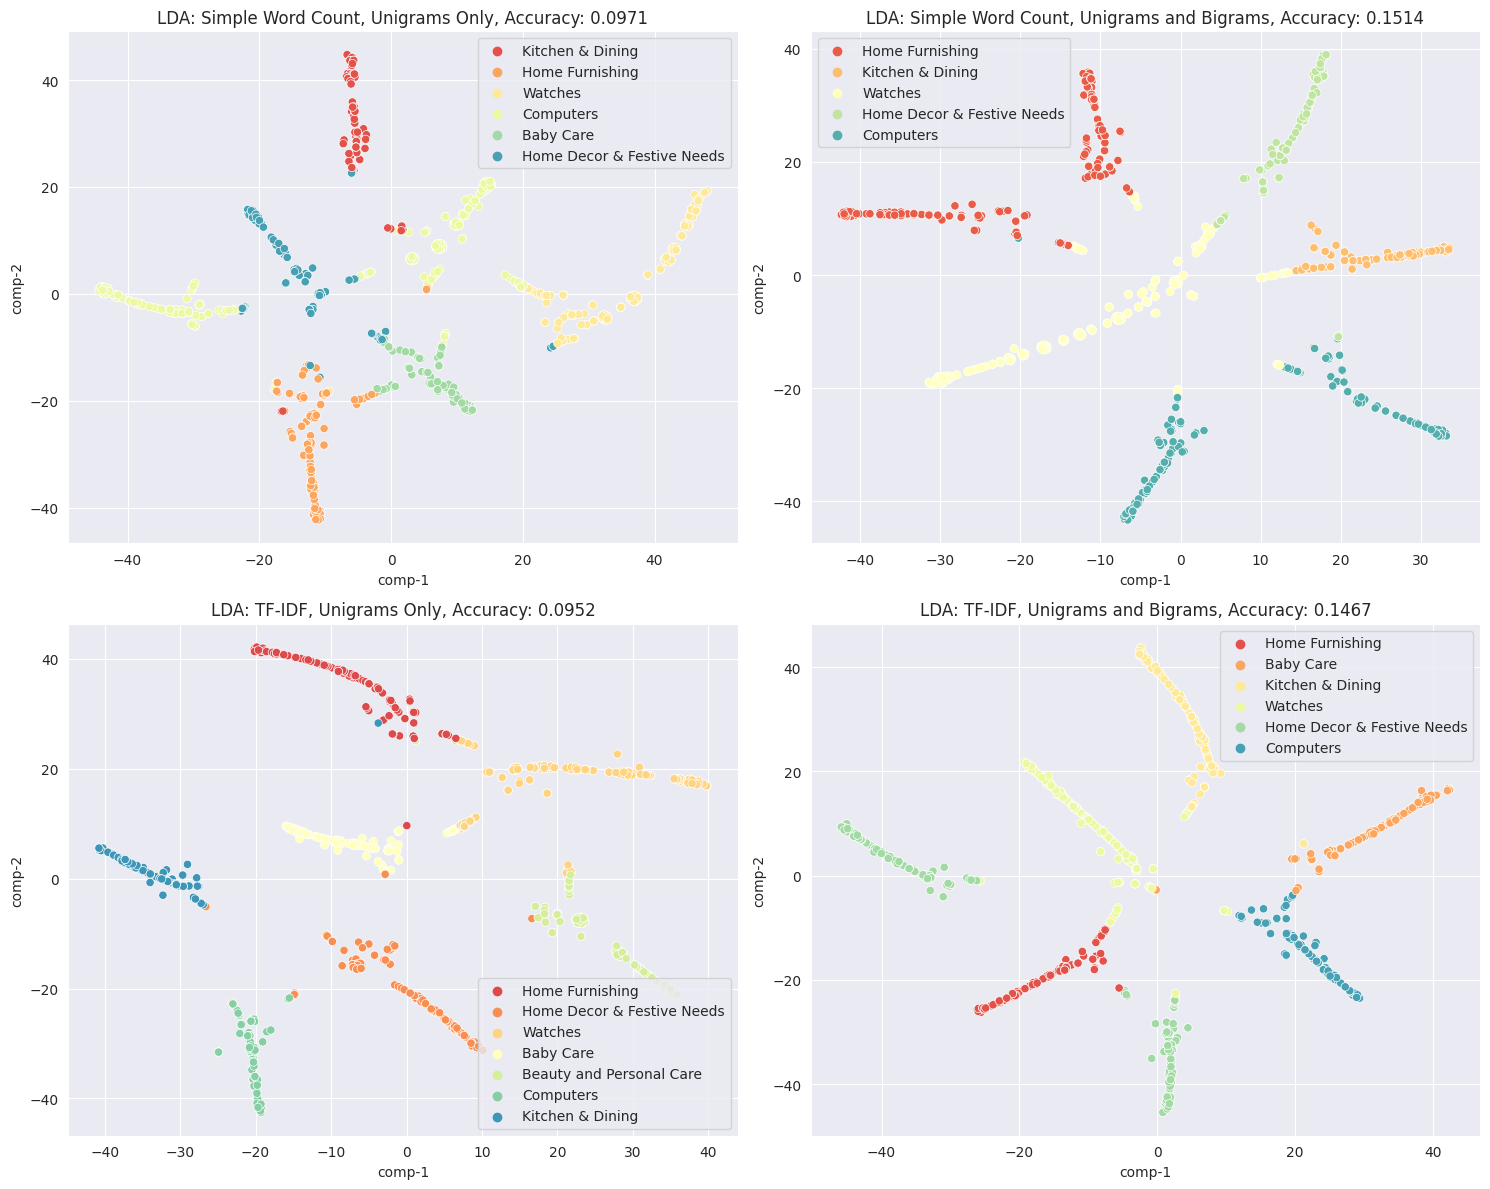

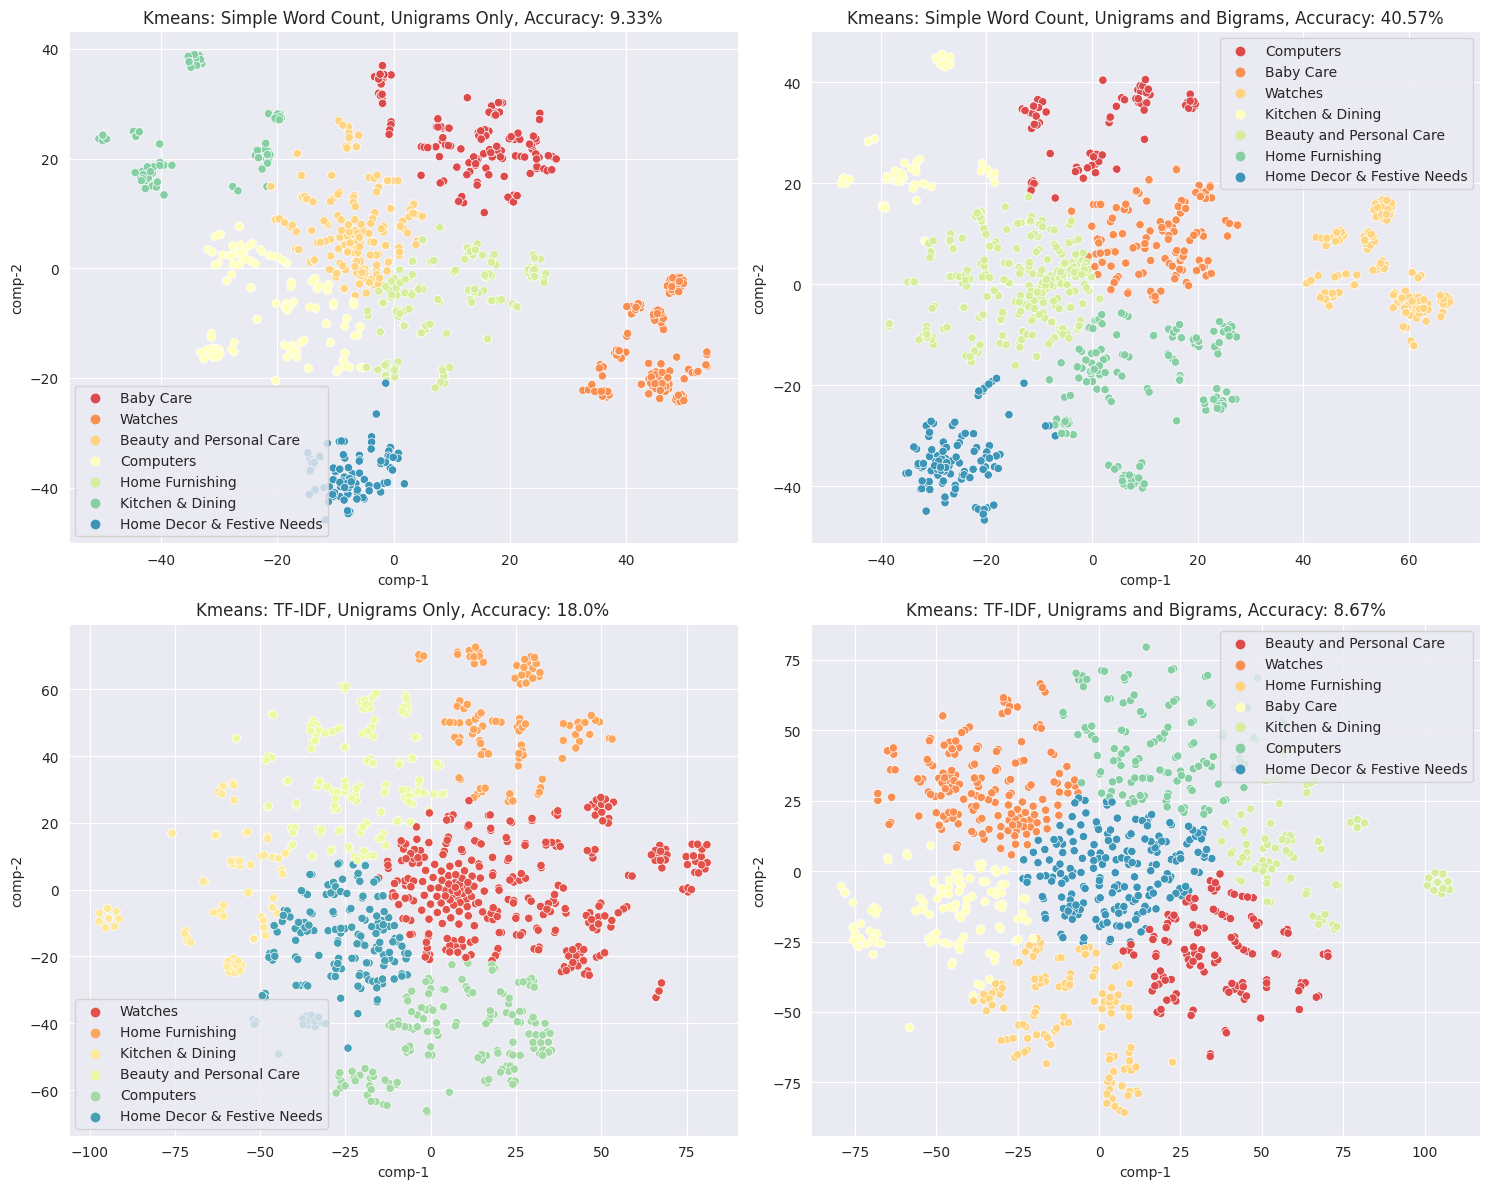

In [18]:
n_topics = len(flipkart_clean_df["subcateg_1"].unique().tolist())
true_categ_names_list = flipkart_clean_df["subcateg_1"].to_list()
true_labels = [
    np.where(np.array(list(dict.fromkeys(true_categ_names_list))) == categ)[0][0]
    for categ in true_categ_names_list
]
docs = flipkart_clean_df["description"].to_list()
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
kmeans_model = KMeans(n_clusters=n_topics, n_init=10, random_state=0)


def get_stemmed_str_list(str_list):
    return [
        " ".join([nltk.stem.PorterStemmer().stem(x) for x in y.split()])
        for y in str_list
    ]


def get_bow_vector_and_feat_names(docs, w_bigram=False, tfidf=False):
    ngram_range = (1, 2) if w_bigram else (1, 1)
    vectorizer = (
        TfidfVectorizer(ngram_range=ngram_range)
        if tfidf
        else CountVectorizer(ngram_range=ngram_range)
    )
    vector = vectorizer.fit_transform(docs)
    feat_names = vectorizer.get_feature_names_out()

    return {"vector": vector, "feat_names": feat_names}


def get_pca_transformed_w_exp_var(matrix, exp_var=0.8):
    if isinstance(matrix, list):
        matrix = np.array(matrix)
    elif isinstance(matrix, scipy.sparse._csr.csr_matrix):
        matrix = matrix.toarray()
    else:
        raise Exception(
            "matrix must be of type `list` or `scipy.sparse._csr.csr_matrix`"
        )

    min_comp = min(matrix.shape)
    n_comp = min_comp
    denom = 2
    step = min_comp // denom

    while step >= 1:
        pca = PCA(n_components=n_comp, random_state=0).fit(matrix)
        explained_variance = sum(pca.explained_variance_ratio_)
        n_comp = n_comp - step if explained_variance > exp_var else n_comp + step
        denom *= 2
        step = min_comp // denom

    return pca.transform(matrix)


def get_2d_tsne(matrix):
    return TSNE(n_components=2, init="random", random_state=0).fit_transform(matrix)


def fit_transform_via_pca_tsne(matrix):
    return get_2d_tsne(get_pca_transformed_w_exp_var(matrix))


def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {}

    for pred_label in sorted(set(pred_labels)):
        categ_name = (
            pd.Series(
                [
                    true_categ_names_list[j]
                    for j in [
                        i
                        for i in range(len(pred_labels))
                        if pred_labels[i] == pred_label
                    ]
                ]
            )
            .value_counts()
            .idxmax()
        )

        label_num_to_name[pred_label] = categ_name
        pred_labels = [x if x != pred_label else categ_name for x in pred_labels]

    return [pred_labels, label_num_to_name]


stemmed_docs = get_stemmed_str_list(docs)
bow_matrices = {
    "Simple Word Count, Unigrams Only": get_bow_vector_and_feat_names(stemmed_docs),
    "Simple Word Count, Unigrams and Bigrams": get_bow_vector_and_feat_names(
        stemmed_docs, w_bigram=True
    ),
    "TF-IDF, Unigrams Only": get_bow_vector_and_feat_names(stemmed_docs, tfidf=True),
    "TF-IDF, Unigrams and Bigrams": get_bow_vector_and_feat_names(
        stemmed_docs, w_bigram=True, tfidf=True
    ),
}


def plot_bow_preds(lda=False):
    ax_idx = 0
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.flatten()
    lda_str = ""

    fig.set_figwidth(15)
    fig.set_figheight(12)

    for bow_matrix_key in bow_matrices.keys():
        if lda:
            lda_matrix = lda_model.fit_transform(bow_matrices[bow_matrix_key]["vector"])
            lda_labels = lda_matrix.argmax(axis=1)
            named_labels, topic_num_to_name_dict = get_named_labels_and_num_to_name(
                lda_labels, true_categ_names_list
            )
            lda_str += f"{bow_matrix_key} - LDA Topics (Top 10 N-grams):\n"

            for index, component in enumerate(lda_model.components_):
                topic_top_feat_list = list(
                    dict(
                        sorted(
                            zip(bow_matrices[bow_matrix_key]["feat_names"], component),
                            key=lambda x: x[1],
                            reverse=True,
                        )[:10]
                    ).keys()
                )
                lda_str += (
                    f"\tTopic {topic_num_to_name_dict[index]}: {topic_top_feat_list}\n"
                )

            tsne = get_2d_tsne(lda_matrix)

            axs[ax_idx].set_title(
                f"LDA: {bow_matrix_key}, Accuracy: {round(accuracy_score(true_labels, lda_labels), 4)}"
            )
        else:
            tsne = fit_transform_via_pca_tsne(bow_matrices[bow_matrix_key]["vector"])
            pred_labels = kmeans_model.fit(tsne).labels_
            named_labels, topic_num_to_name_dict = get_named_labels_and_num_to_name(
                pred_labels, true_categ_names_list
            )

            axs[ax_idx].set_title(
                f"Kmeans: {bow_matrix_key}, Accuracy: {round(accuracy_score(true_labels, pred_labels) * 100, 2)}%"
            )

        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "pred_labels": named_labels,
                    "comp-1": tsne[:, 0],
                    "comp-2": tsne[:, 1],
                }
            ),
            x="comp-1",
            y="comp-2",
            hue="pred_labels",
            palette=sns.color_palette("Spectral", len(set(named_labels))),
            ax=axs[ax_idx],
        )
        axs[ax_idx].legend()
        ax_idx += 1

    if lda:
        print(lda_str)

    plt.tight_layout()
    plt.show()


plot_bow_preds(lda=True)
plot_bow_preds()


Simple Word Count, Unigrams Only - LDA Topics (Top 10 N-grams):
	Topic 0: ['mug', 'coffee', 'laptop', 'happy', 'cheer', 'affordable', 'lapguard', 'holiday', 'say', 'find']
	Topic 1: ['cotton', 'dress', 'towel', 'single', 'bedsheet', 'sonata', 'sheet', 'gathered', 'floral', 'pillow']
	Topic 2: ['showpiece', 'blanket', 'brass', 'pizza', 'oil', 'cutter', 'elephant', 'decor', 'handicraft', 'statue']
	Topic 3: ['watch', 'analog', 'discount', 'dial', 'strap', 'mug', 'rockmantra', 'round', 'maximum', 'dishwasher']
	Topic 4: ['laptop', 'usb', 'polyester', 'pad', 'curtain', 'mouse', 'eyelet', 'door', 'port', 'keyboard']
	Topic 5: ['mug', 'coffee', 'cushion', 'kitchen', 'printland', 'huge', 'serve', 'prithish', 'fantastic', 'glass']
	Topic 6: ['adapter', 'sleeve', 'shirt', 'cotton', 'vaio', 'charger', 'laptop', 'neck', 'smartpro', 'regular']
Simple Word Count, Unigrams and Bigrams - LDA Topics (Top 10 N-grams):
	Topic 0: ['watch', 'analog', 'analog watch', 'discount', 'polyester', 'dial', 'strap

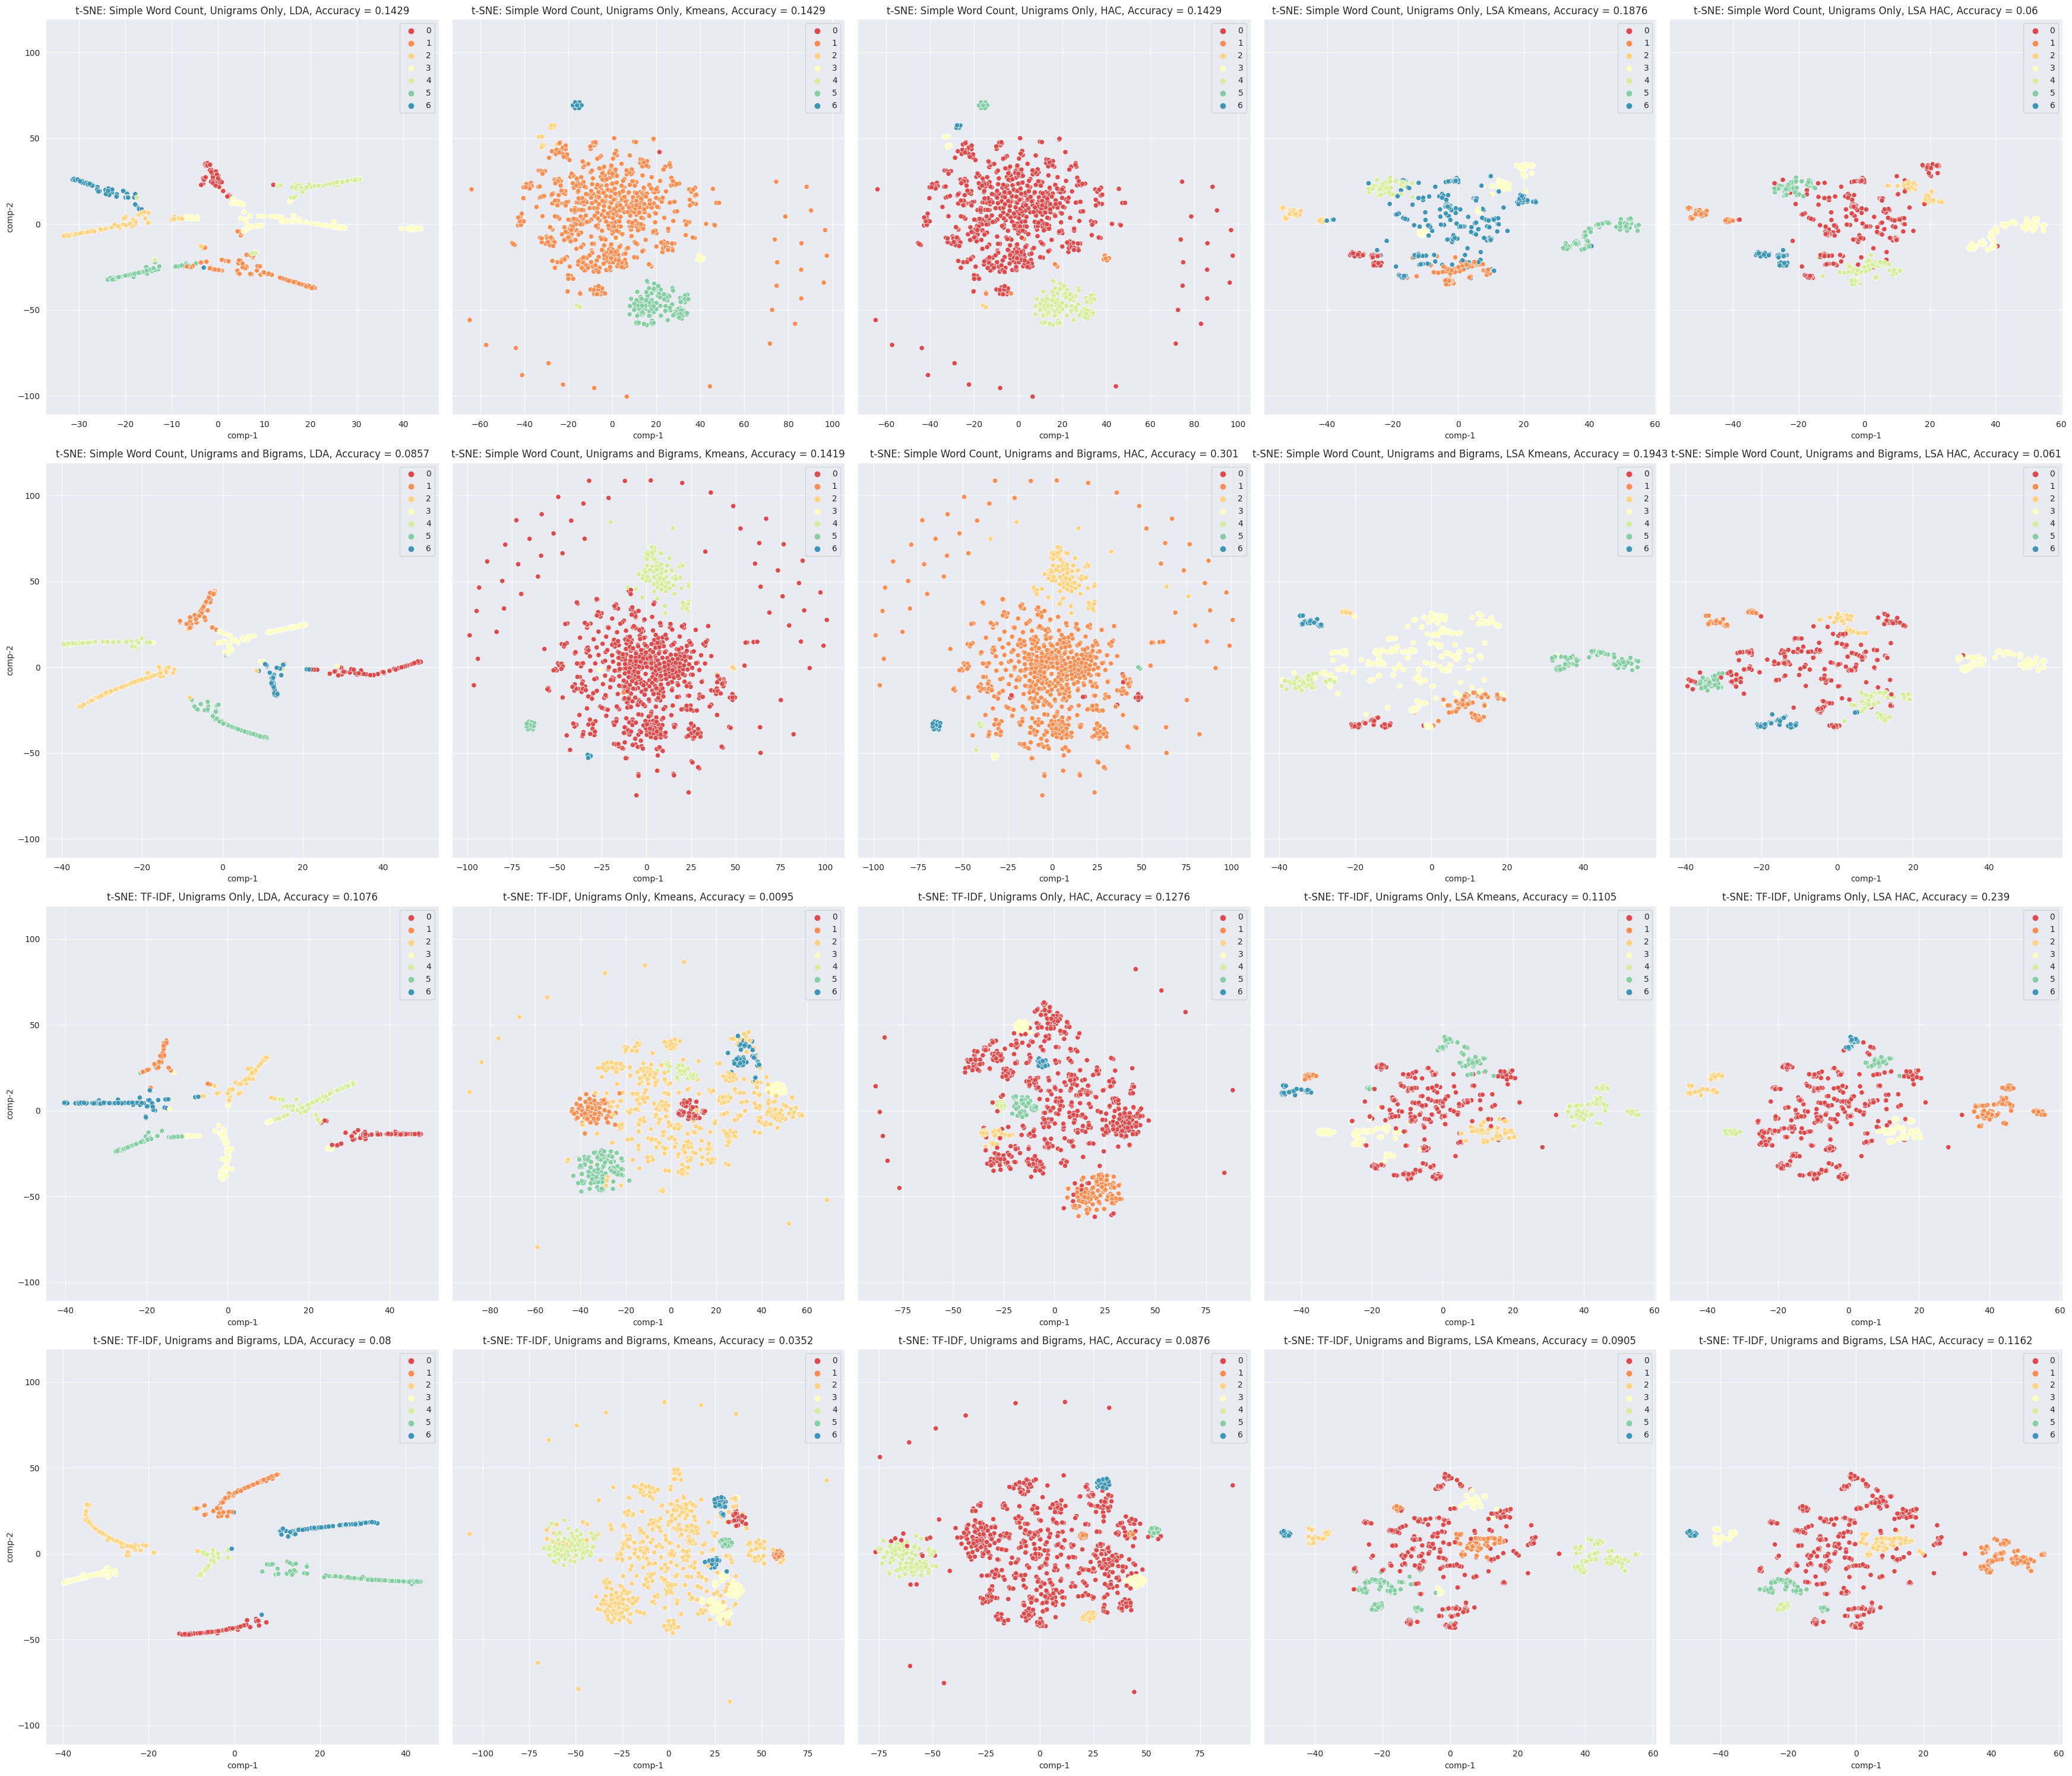

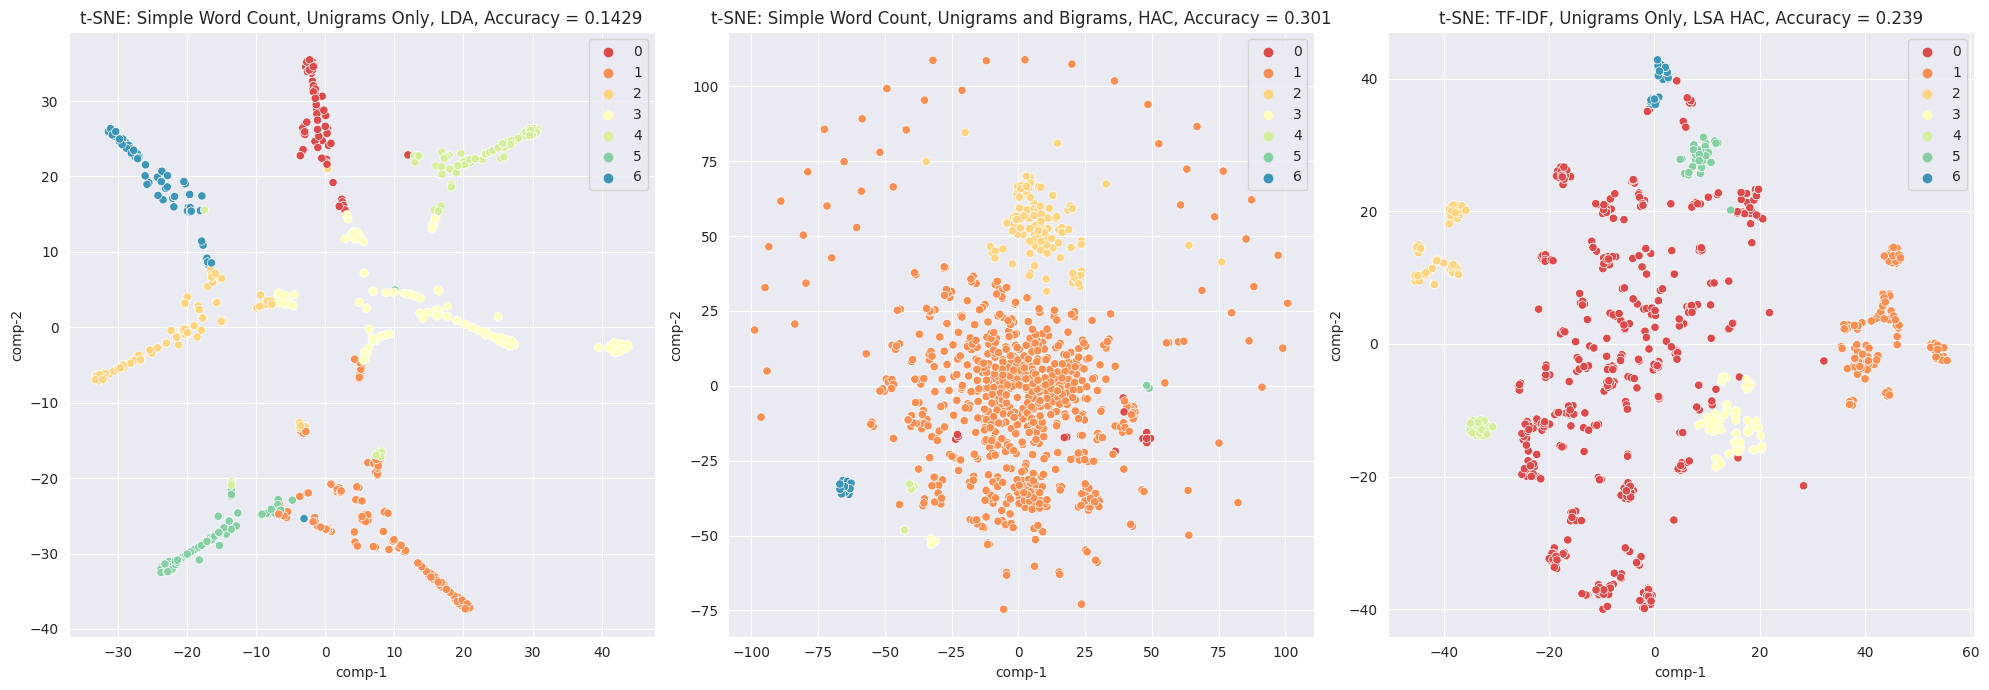

In [19]:
# def get_bow_vector_and_feat_names(docs, w_bigram=False, tfidf=False):
#     ngram_range = (1, 2) if w_bigram else (1, 1)
#     vectorizer = (
#         TfidfVectorizer(ngram_range=ngram_range)
#         if tfidf
#         else CountVectorizer(ngram_range=ngram_range)
#     )
#     vector = vectorizer.fit_transform(docs)
#     feat_names = vectorizer.get_feature_names_out()

#     return {"vector": vector, "feat_names": feat_names}


# stem = lambda xs: " ".join([nltk.stem.PorterStemmer().stem(x) for x in xs.split()])
# n_topics = len(flipkart_clean_df["subcateg_1"].unique().tolist())
# true_labels = [
#     np.where(
#         np.array(list(dict.fromkeys(flipkart_clean_df["subcateg_1"].to_list())))
#         == categ
#     )[0][0]
#     for categ in flipkart_clean_df["subcateg_1"].to_list()
# ]
# docs = flipkart_clean_df["description"].to_list()

# if not os.path.isfile("bow_classif_out.pkl"):
#     bow_strategies = {
#         "Simple Word Count, Unigrams Only": {"w_bigram": False, "tfidf": False},
#         "Simple Word Count, Unigrams and Bigrams": {"w_bigram": True, "tfidf": False},
#         "TF-IDF, Unigrams Only": {"w_bigram": False, "tfidf": True},
#         "TF-IDF, Unigrams and Bigrams": {"w_bigram": True, "tfidf": True},
#     }
#     classificaton_strategies = []
#     lda_str = ""

#     for bow_strategy in bow_strategies.keys():
#         vector_and_feat_names = get_bow_vector_and_feat_names(
#             flipkart_clean_df["description"].to_list(),
#             w_bigram=bow_strategies[bow_strategy]["w_bigram"],
#             tfidf=bow_strategies[bow_strategy]["tfidf"],
#         )
#         lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
#         lda_matrix = lda_model.fit_transform(vector_and_feat_names["vector"])
#         lda_str += f"{bow_strategy} - LDA Topics (Top 10 N-grams):\n"

#         for index, component in enumerate(lda_model.components_):
#             topic_top_feat_list = list(
#                 dict(
#                     sorted(
#                         zip(vector_and_feat_names["feat_names"], component),
#                         key=lambda x: x[1],
#                         reverse=True,
#                     )[:10]
#                 ).keys()
#             )
#             lda_str += f"\tTopic {index}: {topic_top_feat_list}\n"

#         lda_labels = lda_matrix.argmax(axis=1)
#         classificaton_strategies += [
#             {
#                 "strategy": bow_strategy + ", LDA",
#                 "matrix": lda_matrix,
#                 "pred_labels": lda_matrix.argmax(axis=1),
#                 "accuracy": accuracy_score(true_labels, lda_labels),
#                 "tsne": TSNE(
#                     n_components=2, init="random", random_state=0
#                 ).fit_transform(lda_matrix),
#             }
#         ]
#         kmeans_labels = (
#             KMeans(n_clusters=n_topics, n_init=10, random_state=0)
#             .fit(vector_and_feat_names["vector"])
#             .labels_
#         )
#         classificaton_strategies += [
#             {
#                 "strategy": bow_strategy + ", Kmeans",
#                 "matrix": vector_and_feat_names["vector"],
#                 "pred_labels": kmeans_labels,
#                 "accuracy": accuracy_score(true_labels, kmeans_labels),
#                 "tsne": TSNE(
#                     n_components=2, init="random", random_state=0
#                 ).fit_transform(vector_and_feat_names["vector"]),
#             }
#         ]
#         hac_labels = (
#             AgglomerativeClustering(n_clusters=n_topics, linkage="ward")
#             .fit(vector_and_feat_names["vector"].toarray())
#             .labels_
#         )
#         classificaton_strategies += [
#             {
#                 "strategy": bow_strategy + ", HAC",
#                 "matrix": vector_and_feat_names["vector"].toarray(),
#                 "pred_labels": hac_labels,
#                 "accuracy": accuracy_score(true_labels, hac_labels),
#                 "tsne": TSNE(
#                     n_components=2, init="random", random_state=0
#                 ).fit_transform(vector_and_feat_names["vector"].toarray()),
#             }
#         ]
#         lsa_matrix = make_pipeline(
#             TruncatedSVD(n_components=100, random_state=0), Normalizer(copy=False)
#         ).fit_transform(vector_and_feat_names["vector"])
#         lsa_kmeans_labels = (
#             KMeans(n_clusters=n_topics, n_init=10, random_state=0)
#             .fit(lsa_matrix)
#             .labels_
#         )
#         lsa_tsne = TSNE(n_components=2, init="random", random_state=0).fit_transform(
#             lsa_matrix
#         )
#         classificaton_strategies += [
#             {
#                 "strategy": bow_strategy + ", LSA Kmeans",
#                 "matrix": lsa_matrix,
#                 "pred_labels": lsa_kmeans_labels,
#                 "accuracy": accuracy_score(true_labels, lsa_kmeans_labels),
#                 "tsne": lsa_tsne,
#             }
#         ]
#         lsa_hac_labels = (
#             AgglomerativeClustering(n_clusters=n_topics, linkage="ward")
#             .fit(lsa_matrix)
#             .labels_
#         )
#         classificaton_strategies += [
#             {
#                 "strategy": bow_strategy + ", LSA HAC",
#                 "matrix": lsa_matrix,
#                 "pred_labels": lsa_hac_labels,
#                 "accuracy": accuracy_score(true_labels, lsa_hac_labels),
#                 "tsne": lsa_tsne,
#             }
#         ]

#     with open("bow_classif_out.pkl", "wb") as f:
#         pickle.dump([lda_str, classificaton_strategies], f)
# else:
#     with open("bow_classif_out.pkl", "rb") as f:
#         lda_str, classificaton_strategies = pickle.load(f)

# print(lda_str, end="")

# ax_idx = 0
# fig, axs = plt.subplots(nrows=4, ncols=5, sharey=True)
# axs = axs.flatten()

# fig.set_figwidth(35)
# fig.set_figheight(30)

# for classification_strategy in classificaton_strategies:
#     clusters_df = pd.DataFrame(
#         {
#             "pred_labels": classification_strategy["pred_labels"],
#             "comp-1": classification_strategy["tsne"][:, 0],
#             "comp-2": classification_strategy["tsne"][:, 1],
#         }
#     )

#     sns.scatterplot(
#         data=clusters_df,
#         x="comp-1",
#         y="comp-2",
#         hue="pred_labels",
#         palette=sns.color_palette("Spectral", n_topics),
#         ax=axs[ax_idx],
#     )
#     axs[ax_idx].set_title(
#         f"t-SNE: {classification_strategy['strategy']}, Accuracy = {round(classification_strategy['accuracy'], 4)}"
#     )
#     axs[ax_idx].legend()
#     ax_idx += 1

# plt.tight_layout()
# plt.show()

# core_strats = [
#     [x["strategy"] for x in classificaton_strategies if "LDA" in x["strategy"]],
#     [
#         x["strategy"]
#         for x in classificaton_strategies
#         if not "LDA" in x["strategy"] and not "LSA" in x["strategy"]
#     ],
#     [x["strategy"] for x in classificaton_strategies if "LSA" in x["strategy"]],
# ]
# best_strats = []

# for core_strat in core_strats:
#     best_strats += [
#         max(
#             [x for x in classificaton_strategies if x["strategy"] in core_strat],
#             key=lambda x: x["accuracy"],
#         )
#     ]

# ax_idx = 0
# fig, axs = plt.subplots(nrows=1, ncols=3)
# axs = axs.flatten()

# fig.set_figwidth(20)
# fig.set_figheight(7)

# for best_strat in best_strats:
#     clusters_df = pd.DataFrame(
#         {
#             "pred_labels": best_strat["pred_labels"],
#             "comp-1": best_strat["tsne"][:, 0],
#             "comp-2": best_strat["tsne"][:, 1],
#         }
#     )

#     sns.scatterplot(
#         data=clusters_df,
#         x="comp-1",
#         y="comp-2",
#         hue="pred_labels",
#         palette=sns.color_palette("Spectral", n_topics),
#         ax=axs[ax_idx],
#     )
#     axs[ax_idx].set_title(
#         f"t-SNE: {best_strat['strategy']}, Accuracy = {round(best_strat['accuracy'], 4)}"
#     )
#     axs[ax_idx].legend()
#     ax_idx += 1

# plt.tight_layout()
# plt.show()


In [22]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
document_embeddings = []
swc_uni_vect = get_bow_vector_and_feat_names(docs)["vector"]
lda_matrix = LatentDirichletAllocation(
    n_components=n_topics, random_state=0
).fit_transform(swc_uni_vect)
lsa_matrix = make_pipeline(
    TruncatedSVD(n_components=100, random_state=0), Normalizer(copy=False)
).fit_transform(swc_uni_vect)
strats = []

for i, document in enumerate(docs):
    input_ids = torch.tensor(bert_tokenizer.encode(document)).unsqueeze(0)

    with torch.no_grad():
        last_hidden_states = bert_model(input_ids)[0]
        document_embedding = torch.mean(last_hidden_states, dim=1).numpy()[0]

        document_embeddings.append(document_embedding)

display(document_embeddings[0])

# pred_labels = (
#     KMeans(n_clusters=n_topics, n_init=10, random_state=0)
#     .fit(document_embeddings)
#     .labels_
# )
# strats += [
#     {
#         "strategy": "BERT Embedding",
#         "pred_labels": pred_labels,
#         "ari": adjusted_rand_score(true_labels, pred_labels),
#         "tsne": TSNE(n_components=2, random_state=0).fit_transform(
#             np.array(document_embeddings)
#         ),
#     }
# ]

# for strat_matrix in [
#     ["BERT Embedding + LDA", lda_matrix],
#     ["BERT Embedding + LDA + LSA", lsa_matrix],
# ]:
#     for i in range(0, len(docs)):
#         document_embeddings[i] = np.concatenate(
#             [document_embeddings[i], strat_matrix[1][i]]
#         )

#     pred_labels = (
#         KMeans(n_clusters=n_topics, n_init=10, random_state=0)
#         .fit(document_embeddings)
#         .labels_
#     )
#     strats += [
#         {
#             "strategy": strat_matrix[0],
#             "pred_labels": pred_labels,
#             "ari": adjusted_rand_score(true_labels, pred_labels),
#             "tsne": TSNE(n_components=2, random_state=0).fit_transform(
#                 np.array(document_embeddings)
#             ),
#         }
#     ]

# ax_idx = 0
# fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True)
# axs = axs.flatten()

# fig.set_figwidth(20)
# fig.set_figheight(7)

# for strat in strats:
#     sns.scatterplot(
#         data=pd.DataFrame(
#             {
#                 "pred_labels": strat["pred_labels"],
#                 "comp-1": strat["tsne"][:, 0],
#                 "comp-2": strat["tsne"][:, 1],
#             }
#         ),
#         x="comp-1",
#         y="comp-2",
#         hue="pred_labels",
#         palette=sns.color_palette("Spectral", n_topics),
#         ax=axs[ax_idx],
#     )
#     axs[ax_idx].set_title(f"t-SNE: {strat['strategy']}, ARI = {round(strat['ari'], 4)}")
#     axs[ax_idx].legend()
#     ax_idx += 1

# plt.tight_layout()
# plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


array([ 2.70356119e-01, -5.67532852e-02,  8.60066295e-01, -4.80375290e-02,
        4.56740826e-01,  3.03619415e-01, -1.02933817e-01,  2.79814661e-01,
       -2.23806966e-02, -2.83160150e-01, -8.55056867e-02,  1.27012834e-01,
        2.10477442e-01,  5.24344325e-01, -1.72704279e-01,  5.64109385e-02,
        9.64940041e-02,  6.98928609e-02, -1.58352286e-01,  8.63723084e-02,
        5.20363808e-01, -1.81452513e-01, -2.23939255e-01,  2.47086257e-01,
        3.71046603e-01, -5.30958712e-01, -2.68758714e-01, -2.46849865e-01,
        4.31362242e-01,  5.99896014e-02,  4.95725662e-01,  2.18598828e-01,
        1.67152062e-02,  3.03887248e-01,  3.46922725e-01, -6.21199369e-01,
       -2.49114841e-01,  4.42655012e-02, -5.47832549e-01,  3.38840157e-01,
       -4.30332214e-01, -4.93542939e-01,  1.68668404e-01,  1.53194860e-01,
       -7.34222308e-02, -4.29829657e-01, -8.27501491e-02,  2.13653073e-01,
        3.36610138e-01,  5.90128917e-03, -7.22263575e-01, -4.06908154e-01,
        5.22411875e-02, -

In [62]:
# Convert preprocessed documents into TaggedDocuments for input into Doc2Vec
# tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(docs)]
tagged_docs = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(docs)]

# Train a Doc2Vec model on the tagged documents
doc2vec_model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=1, epochs=50)

# Get the document vectors from the Doc2Vec model
doc_vectors = [doc2vec_model.infer_vector(doc.words) for doc in tagged_docs]

print(len(doc_vectors))

# for i in range(0, len(docs)):
#     doc_vectors[i] = np.concatenate(
#         [doc_vectors[i], lda_matrix[i]]
#     )

# # Train an SVM classifier on the document vectors
# svm_classifier = SVC(kernel='linear', C=1, decision_function_shape='ovr')
# svm_classifier.fit(doc_vectors)

# # Predict the labels of the documents using the SVM classifier
# predicted_labels = svm_classifier.predict(doc_vectors)

# # Evaluate the performance using ARI
# ari = adjusted_rand_score(true_labels, predicted_labels)
# print(f"Adjusted Rand Index: {ari:.4f}")

# # Visualize the results using t-SNE
# tsne = TSNE(n_components=2)
# tsne_embeddings = tsne.fit_transform(np.array(doc_vectors))

# plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=true_labels)
# plt.title("True Labels")
# plt.show()

# plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=predicted_labels)
# plt.title("Predicted Labels")
# plt.show()


1050
